# Analysis of the Text Variables

In [5]:
#from load_data import *

#from helpers import clean_comments
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import collections
from langdetect import detect
from deep_translator import GoogleTranslator

from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

#from textblob import TextBlob

#import transformers
#import shap
from re import sub

In [2]:
def clean_comments(text):
    ''' Pre process and convert texts to a list of words
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)
    text = sub(r"\s+$", "", text)

    # they were weird
    text = text.replace("br/", "")

    return text

In [3]:
url_listing = "http://data.insideairbnb.com/germany/bv/munich/2021-12-24/data/listings.csv.gz"
url_reviews = "http://data.insideairbnb.com/germany/bv/munich/2021-12-24/data/reviews.csv.gz"
listings = pd.read_csv(url_listing)
reviews = pd.read_csv(url_reviews)

## Reviews

clean reviews, detect language (english = 1, else = 0) and translate if necessary

In [30]:
reviews_f = reviews["comments"].apply(lambda x: clean_comments(x))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [23]:
langs = []
def det_and_trans(review):
    if len(review) == 0:
        langs.append(1)
        return review
    if not review.islower():
        langs.append(1)
        return review
    det_lan = detect(review)
    check = det_lan == "en"
    if not check:
        translation = GoogleTranslator(source='auto', target='en').translate(review)
        langs.append(0)
        return translation
    else:
        langs.append(1)
        return review

In [ ]:
#started at 16:30
for i in range(len(reviews_f)):
    reviews_f[i] = det_and_trans(reviews_f[i])
    print(i)

reviews_df = pd.DataFrame(
    {"listing_id": reviews["listing_id"],
     "reviews": reviews_f,
     "lang": langs_f
     })


reviews_df.to_csv("trans_reviews_munich.csv")

In [6]:
reviews_f_read = pd.read_csv("trans_reviews_munich.csv")

# replace NaNs with space
reviews_f = reviews_f_read["reviews"]
for i in range(len(reviews_f)):
    if type(reviews_f[i]) == float:
        reviews_f[i] = " "

langs_df = reviews_f_read["lang"]

# Portion of english reviews?
np.mean(langs_df).round(4) * 100

C:\Users\49173\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


70.47

## Wordcloud

Let's look at some word frequencies

In [8]:
# Word Frequency
def convert(lst):
    return ([i for item in lst for i in item.split()])

all_words_review = convert(reviews_f)

count_word = collections.Counter(all_words_review) #Count word frequency
clean_word_count = pd.DataFrame(count_word.most_common(10),
                             columns=['words', 'count'])

# So let us remove stop words
stop_words = set(stopwords.words(['english']))
# Add some words after analysing
freq_airbnb = ["us", "would", "host", "house", "room", "city", "apartment",
               "location", "munich", "place", "stay", "de", "also", "munich"]
stop_words.update(freq_airbnb)


# View a few words from the set
list(stop_words)[0:10]

['o', 'y', 'ma', 'other', "wouldn't", 'this', 'us', 'have', 'hadn', 'before']

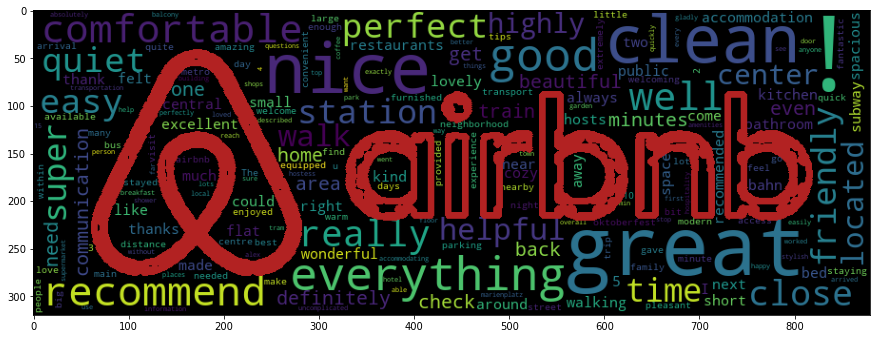

In [13]:
words_review_cleaned = [word for word in all_words_review if word not in stop_words]
words_review_count = collections.Counter(words_review_cleaned)

mask = np.array(Image.open("../text_data/AirBnB.jpeg"))
#mask = np.array(Image.open("AirBnB_munich.jpeg"))

wordcloud = WordCloud(width = 1000, height = 500, mask = mask, #background_color="white",
                      contour_width=10, contour_color='firebrick').generate_from_frequencies(words_review_count)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.show()

### Sentiment Analysis

In [14]:
# "no problem(s)" and "no complaints" only was quite negative and special cases do not validate on their own
def no_prob_to_good(review, term):
    if term in review:
        if len(review.split()) < 5:
            review = "We did not have any problems."
    return review

term = "no problem"
for i in range(len(reviews_f)):
    reviews_f[i] = no_prob_to_good(reviews_f[i], term=term)

term = "no complaint"
for i in range(len(reviews_f)):
    reviews_f[i] = no_prob_to_good(reviews_f[i], term=term)

C:\Users\49173\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\49173\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### NLTK

Neutral, Negativity and Positivity sum up to 1 (like how much of what is in it)
Compound is a weighted normalized (-1,1) score of the sum of the valence -> Sentiment of entire text.

In [15]:
# Polarity Scores
sid = SentimentIntensityAnalyzer()
#sid.constants.SPECIAL_CASE_IDIOMS.update({"no problem" : 1.5, "no problems" : 1.5}) # "no problem(s)" was very negative
pscores = [sid.polarity_scores(comment) for comment in reviews_f]

Histograms of different Polarity Scores

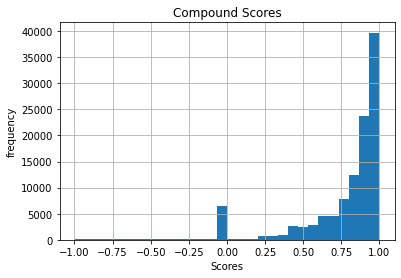

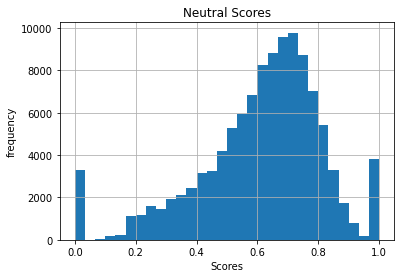

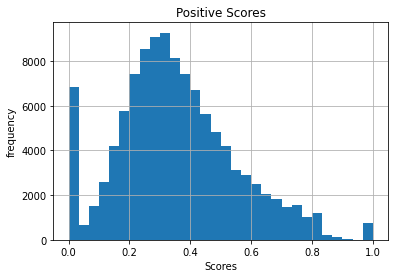

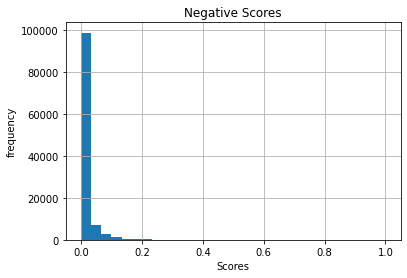

In [16]:
#Histogram plot neutral
pd.Series([score['compound'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Compound Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

#Histogram plot neutral
pd.Series([score['neu'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Neutral Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

#Histogram plot positive
pd.Series([score['pos'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Positive Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

#Histogram plot negative
pd.Series([score['neg'] for score in pscores]).plot(kind='hist', grid = True, bins = 30)

plt.title('Negative Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

plt.show()

In [17]:
#Create dataframe for sentiment analysis
scored_reviews = pd.DataFrame()
scored_reviews["listing_id"] = reviews["listing_id"]
scored_reviews["english_review"] = langs_df
scored_reviews['review'] = [r for r in reviews_f]
scored_reviews['compound'] = [score['compound'] for score in pscores]
scored_reviews['negativity'] = [score['neg'] for score in pscores]
scored_reviews['neutrality'] = [score['neu'] for score in pscores]
scored_reviews['positivity'] = [score['pos'] for score in pscores]

### Review further

Add length of review, too.
Also it might be interesting how many negative reviews for each listing there are, so create a boolean variable displaying whether there is a negative compound.

In [18]:
scored_reviews["review_length"] = scored_reviews["review"].apply(lambda x: len(x))
scored_reviews["negative_comp"] = scored_reviews["compound"] < 0
del scored_reviews["review"]
scored_reviews

,listing_id,english_review,compound,negativity,neutrality,positivity,review_length,negative_comp
0,97945,1,0.9733,0.000,0.711,0.289,388,False
1,97945,1,0.9771,0.000,0.774,0.226,541,False
2,97945,1,0.8516,0.000,0.775,0.225,211,False
3,97945,1,0.9940,0.000,0.692,0.308,792,False
4,97945,1,0.9390,0.027,0.788,0.185,508,False
...,...,...,...,...,...,...,...,...
111574,53748144,0,0.6249,0.000,0.196,0.804,17,False
111575,53766641,1,0.8350,0.000,0.612,0.388,106,False
111576,53788448,0,0.7564,0.000,0.629,0.371,74,False
111577,53788448,1,0.6800,0.000,0.589,0.411,59,False


Grouping be the id.

In [19]:
listings_reviews_min = scored_reviews.groupby(["listing_id"]).min()
listings_reviews_max = scored_reviews.groupby(["listing_id"]).max()
listings_reviews_mean = scored_reviews.groupby(["listing_id"]).mean()
listings_reviews_sum = scored_reviews.groupby(["listing_id"]).sum()

extr_col = listings_reviews_min["compound"]
extr_col = pd.concat([extr_col, listings_reviews_max["compound"]], axis = 1)
extr_col.columns = ["most_neg_compound", "most_pos_compound"]

# give all the sums a prefix in their column names
listings_reviews_mean = listings_reviews_mean.add_prefix("mean_")

# combine
listings_reviews = pd.concat([listings_reviews_mean, extr_col], axis=1)
listings_reviews.reset_index(inplace=True)
listings_reviews.columns = ["id", "prop_of_eng_reviews", "mean_compound", "mean_negativity", "mean_neutrality", 
                            "mean_positivity", "mean_review_length", "prop_of_neg_comp", "most_neg_compound",
                            "most_pos_compound"]

listings_reviews

,id,prop_of_eng_reviews,mean_compound,mean_negativity,mean_neutrality,mean_positivity,mean_review_length,prop_of_neg_comp,most_neg_compound,most_pos_compound
0,97945,0.992248,0.843488,0.009395,0.663147,0.288667,298.891473,0.000000,0.0000,0.9944
1,114695,1.000000,0.894472,0.006755,0.686509,0.306717,299.264151,0.000000,0.4576,0.9950
2,127383,0.980198,0.853041,0.007525,0.646426,0.336119,234.366337,0.009901,-0.1531,0.9921
3,159634,0.970588,0.743862,0.012324,0.702941,0.284765,335.941176,0.029412,-0.9741,0.9924
4,170154,0.977823,0.878723,0.007405,0.638996,0.325379,324.600806,0.002016,-0.3578,0.9972
...,...,...,...,...,...,...,...,...,...,...
3807,53730546,0.000000,0.599400,0.000000,0.000000,1.000000,5.000000,0.000000,0.5994,0.5994
3808,53748144,0.000000,0.624900,0.000000,0.196000,0.804000,17.000000,0.000000,0.6249,0.6249
3809,53766641,1.000000,0.835000,0.000000,0.612000,0.388000,106.000000,0.000000,0.8350,0.8350
3810,53788448,0.500000,0.718200,0.000000,0.609000,0.391000,66.500000,0.000000,0.6800,0.7564


In [20]:
listings_reviews.to_csv("listings_reviews_munich.csv")

## Further Text

Which are: ["name", "host_name", "description", "neighborhood_overview", "host_about"]
Name - "Name of the listing"
host_name - "Name of the host. Usually just the first name(s)."
description: "Detailed description of the listing"
neighbourhood_overview: "Host's description of the neighbourhood"
host_about: "Description about the host"

All these variables are written by the host (or naturally given, like their name).
It might have an effect how much effort to shine or how much love they put in the
descriptions. So the length could be a proper variable.

Try sentiments at description, neighbourhood_overview and host_about.

In [21]:
text_col = ["name", "host_name", "description", "neighborhood_overview", "host_about"]

listings["name_length"] = listings["name"].apply(lambda x: len(x))
listings["description_length"] = listings["description"].apply(lambda x: len(x))
listings["neighborhood_overview_length"] = listings["neighborhood_overview"].apply(lambda x: len(x))
listings["host_about_length"] = listings["host_about"].apply(lambda x: len(x))

TypeError: object of type 'float' has no len()

### Sentiment Analysis
of "description", "neighborhood_overview", "host_about"

In [42]:
# name and description, take room_type instead
ind = listings[listings["name"].isna()]["name"].index
listings["name"].loc[ind] = listings["room_type"].loc[ind]

ind = listings[listings["description"].isna()]["description"].index
listings["description"].loc[ind] = listings["room_type"].loc[ind]

# neighbourhood-overview (=description) just neihgbourhood cleansed
ind = listings[listings["neighborhood_overview"].isna()]["neighborhood_overview"].index
listings["neighborhood_overview"].loc[ind] = listings["neighbourhood_cleansed"].loc[ind]

C:\Users\49173\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [44]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [47]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bs
from urllib.parse import urljoin
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import halfnorm

In [48]:
host_var = ["host_name", "host_since", #"host_is_superhost",
            "host_listings_count"] #, "host_identity_verified"]
listings.isna().sum()[host_var]
ind_s = listings[listings["host_name"].isna()]["host_name"].index
rel_URL = listings.loc[ind_s]["host_url"]
ids = listings["id"].loc[ind_s]

name = []
id_ver = []
for i in range(len(ind_s)):
    listings["host_listings_count"].loc[ind_s]= len(listings[listings.id == ids.values[i]])
    session = requests.Session()
    html_code = session.get(rel_URL.values[i]).content
    soup = bs(html_code, "html.parser")
    name_html = soup.select("._a0kct9 ._14i3z6h")
    verified_html = soup.select("._p03egf+ ._p03egf ._1ax9t0a")
    if len(name_html) == 0:
        name.append("Anonymous")
    else:
        name.append(name_html[0].text[8:])
    if len(verified_html) == 0:
        id_ver.append(0)
    else:
        id_ver.append(1)


listings["host_name"].loc[ind_s] = name
#listings["host_identity_verified"].loc[ind_s] = id_ver
#listings["host_is_superhost"].loc[ind_s] = 0
listings["host_since"].loc[ind_s] = listings["first_review"].loc[ind_s]

# host_about
ind = listings[listings["host_about"].isna()]["host_about"].index
listings["host_about"].loc[ind] = " "

C:\Users\49173\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [49]:
# Translation and language used by the Host
list_name = listings["name"].apply(lambda x: clean_comments(x))
descr = listings["description"].apply(lambda x: clean_comments(x))
neigh_over = listings["neighborhood_overview"].apply(lambda x: clean_comments(x))
host_ab = listings["host_about"].apply(lambda x: clean_comments(x))


# check if all are english
langs = []
for i in range(len(listings)):
    list_name[i] = det_and_trans(list_name[i])
    descr[i] = det_and_trans(descr[i])
    neigh_over[i] = det_and_trans(neigh_over[i])
    host_ab[i] = det_and_trans(host_ab[i])
    print(i)

list_name_lang = langs[::4]
descr_lang = langs[1::4]
neigh_over_lang = langs[2::4]
host_ab_lang = langs[3::4]

eng_host = []
for i in range(len(descr_lang)):
    lang_sum = list_name_lang[i] + descr_lang[i] + neigh_over_lang[i] + host_ab_lang[i]
    if lang_sum <= 1:
        eng_host.append(0)
    else:
        eng_host.append(1)


host_lang = pd.DataFrame(
    {"list_name": list_name,
     "descr": descr,
     "neigh_over": neigh_over,
     "host_ab": host_ab,
     "eng_host": eng_host
     })

host_lang.to_csv("host_lang_munich.csv")

host_lang = pd.read_csv("host_lang_munich.csv")

for i in range(len(host_lang)):
    if type(host_lang["list_name"][i]) == float:
        host_lang["list_name"][i] = " "
    if type(host_lang["descr"][i]) == float:
        host_lang["descr"][i] = " "
    if type(host_lang["neigh_over"][i]) == float:
        host_lang["neigh_over"][i] = " "
    if type(host_lang["host_ab"][i]) == float:
        host_lang["host_ab"][i] = " "

host_lang

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

C:\Users\49173\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\49173\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\49173\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\4917

,Unnamed: 0,list_name,descr,neigh_over,host_ab,eng_host
0,0,deluxw apartm with roof terrace,b the space /b br / we offer a modern quiet a...,we are living in a outskirt of munich its call...,I'm looking forward to many international gues...,1
1,1,apartment munich/east with sundeck,b the space /b br / it s a quiet and sunny ap...,mountain am laim,i am looking forward to meet interesting peopl...,1
2,2,city apartment next to pinakothek,b the space /b br / my cosy apartment is loca...,maxvorstadt,hi my name is sonja and i am happy to accommod...,1
3,3,fancy bright central roof top flat and homeoffice,in this idyllic stylish flat you live very qui...,very quiet green squirrels and beergardens around,outdoorsy sportive person from munich i love t...,1
4,4,own floor bath parking breakfast,enjoy a quiet neighbourhood easy access to the...,sendling westpark,we love to travel and dream of living in a hou...,1
...,...,...,...,...,...,...
4990,4990,tiny house holzofen lodge,there is a well with good water and a power co...,pasing obermenzing,,1
4991,4991,house with garden in the green west of munich,only 6 minutes away from pasinger marienplatz ...,pasing obermenzing,,0
4992,4992,your new home in munich beautiful room,we rent top-equipped rooms with their own wash...,very quiet residential area,,0
4993,4993,modern 125sqm 2br apartment carpark olympia park,our apartment has suited our family of four we...,milbertshofen am hart,we love to travel and host !,1


In [50]:
#Sentiment Analysis

# Polarity Scores
sid = SentimentIntensityAnalyzer()
pscores_name = [sid.polarity_scores(comment) for comment in host_lang["list_name"]]
pscores_descr = [sid.polarity_scores(comment) for comment in host_lang["descr"]]
pscores_neigh_over = [sid.polarity_scores(comment) for comment in host_lang["neigh_over"]]
pscores_host_ab = [sid.polarity_scores(comment) for comment in host_lang["host_ab"]]

host_sent = pd.DataFrame()
host_sent["id"] = listings["id"]
host_sent["english_writing_host"] = host_lang["eng_host"]
host_sent['name'] = [r for r in host_lang["list_name"]]
host_sent['descr'] = [r for r in host_lang["descr"]]
host_sent['neigh_over'] = [r for r in host_lang["neigh_over"]]
host_sent['host_ab'] = [r for r in host_lang["host_ab"]]
host_sent['compound_name'] = [score['compound'] for score in pscores_name]
host_sent['negativity_name'] = [score['neg'] for score in pscores_name]
host_sent['neutrality_name'] = [score['neu'] for score in pscores_name]
host_sent['positivity_name'] = [score['pos'] for score in pscores_name]
host_sent['compound_descr'] = [score['compound'] for score in pscores_descr]
host_sent['negativity_descr'] = [score['neg'] for score in pscores_descr]
host_sent['neutrality_descr'] = [score['neu'] for score in pscores_descr]
host_sent['positivity_descr'] = [score['pos'] for score in pscores_descr]
host_sent['compound_neigh_over'] = [score['compound'] for score in pscores_neigh_over]
host_sent['negativity_neigh_over'] = [score['neg'] for score in pscores_neigh_over]
host_sent['neutrality_neigh_over'] = [score['neu'] for score in pscores_neigh_over]
host_sent['positivity_neigh_over'] = [score['pos'] for score in pscores_neigh_over]
host_sent['compound_host_ab'] = [score['compound'] for score in pscores_host_ab]
host_sent['negativity_host_ab'] = [score['neg'] for score in pscores_host_ab]
host_sent['neutrality_host_ab'] = [score['neu'] for score in pscores_host_ab]
host_sent['positivity_host_ab'] = [score['pos'] for score in pscores_host_ab]

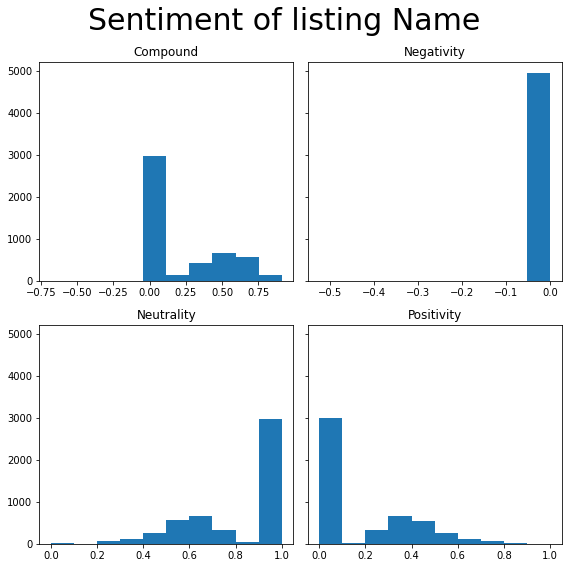

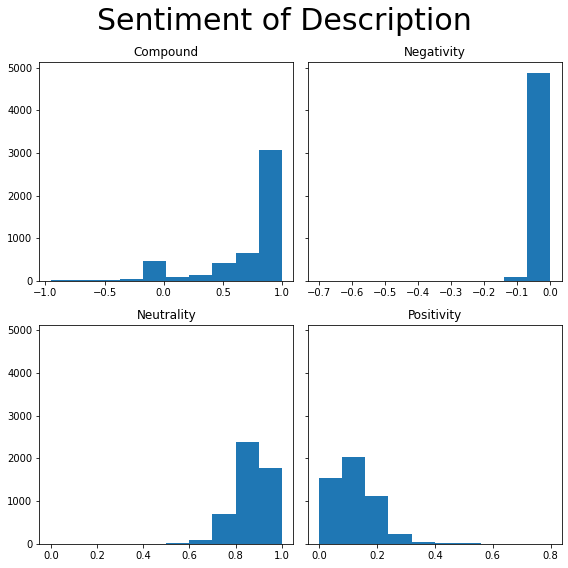

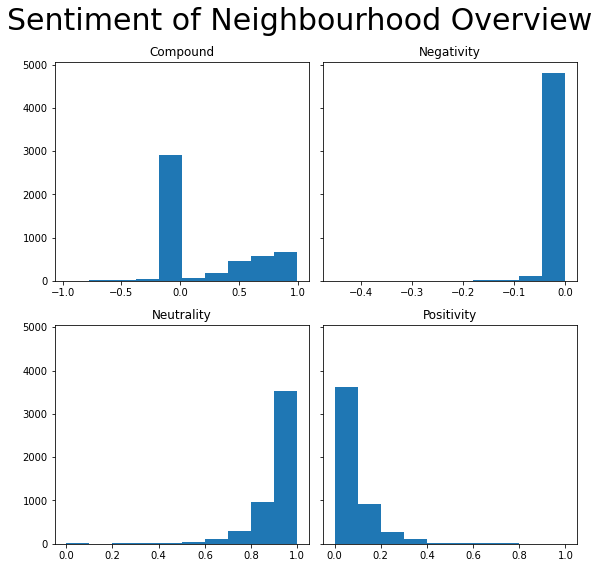

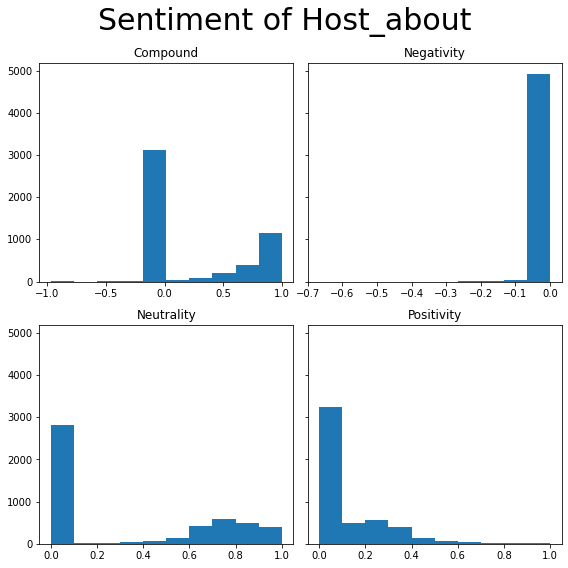

In [51]:
# set figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
fig.suptitle('Sentiment of listing Name', fontsize=30)
# plot to different axes
ax[0,0].hist(host_sent['compound_name'])
ax[0,0].set_title("Compound")
ax[0,1].hist(-host_sent['negativity_name'])
ax[0,1].set_title("Negativity")
ax[1,0].hist(host_sent['neutrality_name'])
ax[1,0].set_title("Neutrality")
ax[1,1].hist(host_sent['positivity_name'])
ax[1,1].set_title("Positivity")

plt.tight_layout()
plt.show()

# set figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
fig.suptitle('Sentiment of Description', fontsize=30)
# plot to different axes
ax[0,0].hist(host_sent['compound_descr'])
ax[0,0].set_title("Compound")
ax[0,1].hist(-host_sent['negativity_descr'])
ax[0,1].set_title("Negativity")
ax[1,0].hist(host_sent['neutrality_descr'])
ax[1,0].set_title("Neutrality")
ax[1,1].hist(host_sent['positivity_descr'])
ax[1,1].set_title("Positivity")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
fig.suptitle('Sentiment of Neighbourhood Overview', fontsize=30)
# plot to different axes
ax[0,0].hist(host_sent['compound_neigh_over'])
ax[0,0].set_title("Compound")
ax[0,1].hist(-host_sent['negativity_neigh_over'])
ax[0,1].set_title("Negativity")
ax[1,0].hist(host_sent['neutrality_neigh_over'])
ax[1,0].set_title("Neutrality")
ax[1,1].hist(host_sent['positivity_neigh_over'])
ax[1,1].set_title("Positivity")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharey=True)
fig.suptitle('Sentiment of Host_about', fontsize=30)
# plot to different axes
ax[0,0].hist(host_sent['compound_host_ab'])
ax[0,0].set_title("Compound")
ax[0,1].hist(-host_sent['negativity_host_ab'])
ax[0,1].set_title("Negativity")
ax[1,0].hist(host_sent['neutrality_host_ab'])
ax[1,0].set_title("Neutrality")
ax[1,1].hist(host_sent['positivity_host_ab'])
ax[1,1].set_title("Positivity")

plt.tight_layout()
plt.show()

In [52]:
host_sent = host_sent.drop(['compound_name', 'negativity_name', 'neutrality_name', 'positivity_name'], axis = 1)

We are done, so drop the text columns

In [53]:
host_sent = host_sent.drop(["name", "descr", "neigh_over", "host_ab"], axis = 1)
host_sent.head(5)
host_sent.to_csv("host_sent_munich.csv")

In [54]:
host_sent

,id,english_writing_host,compound_descr,negativity_descr,neutrality_descr,positivity_descr,compound_neigh_over,negativity_neigh_over,neutrality_neigh_over,positivity_neigh_over,compound_host_ab,negativity_host_ab,neutrality_host_ab,positivity_host_ab
0,97945,1,0.8805,0.000,0.930,0.070,0.552,0.0,0.855,0.145,0.8122,0.0,0.670,0.330
1,114695,1,0.5423,0.013,0.952,0.035,0.000,0.0,1.000,0.000,0.8658,0.0,0.749,0.251
2,127383,1,0.9459,0.000,0.901,0.099,0.000,0.0,1.000,0.000,0.7777,0.0,0.639,0.361
3,159634,1,0.9559,0.000,0.892,0.108,0.000,0.0,1.000,0.000,0.7717,0.0,0.839,0.161
4,170154,1,0.9396,0.000,0.885,0.115,0.000,0.0,1.000,0.000,0.9732,0.0,0.619,0.381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4990,53933449,1,0.6249,0.028,0.877,0.094,0.000,0.0,1.000,0.000,0.0000,0.0,0.000,0.000
4991,53935376,0,0.5994,0.000,0.954,0.046,0.000,0.0,1.000,0.000,0.0000,0.0,0.000,0.000
4992,53936793,0,0.5859,0.000,0.849,0.151,0.000,0.0,1.000,0.000,0.0000,0.0,0.000,0.000
4993,53945865,1,0.9080,0.000,0.840,0.160,0.000,0.0,1.000,0.000,0.6696,0.0,0.527,0.473


## Host Name

The idea is to check for racism, so we use NamePrism to check which ethnic usually goes hand in hand with a name.
https://name-prism.com/

Six ethnicity/races are considered in our ethnicity classifier: 
White, Black, API (Asian and Pacific Islander), AIAN (American Indian and Alaska Native), 2PRACE (more than 2 race) and Hispanic.

In [55]:
host_names = listings["host_name"]

### The old/own way

In [56]:
names = pd.read_csv("../text_data/name-census-top-100.csv", sep =";")

In [57]:

# due to https://en.wikipedia.org/wiki/Western_Europe#UN_geoscheme_classification
west_europe = ["Austria", "Belgium", "Denmark", "Finland", "France",
               "Germany", "Ireland", "Jersey","Luxembourg", "Netherlands",
               "Norway", "Sweden", "Switzerland", "United Kingdom"]
south_europe = ["Cyprus", "Greece", "Italy", "Portugal", "Spain"]
east_europe = ["Albania", "Belarus", "Bulgaria", "Bosnia and Herzegovina", "Croatia",
               "Czech Republic", "Hungary", "Kosovo", "Latvia", "Lithuania", "Macedonia",
               "Poland", "Romania", "Russia", "Serbia", "Slovakia", "Slovenia", "Ukraine"]

# https://www.worldmap-knowledge.com/articles/the-four-regions-of-asia.html
central_asia = ["Kazakhstan"]
east_asia = ["China", "Hong Kong", "Japan", "South Korea", "Taiwan"]
south_asia = ["Afghanistan", "Bangladesh", "India", "Iran", "Nepal", "Pakistan"]
south_east_asia = ["Indonesia", "Malaysia", "Philippines", "Singapore",
                   "Thailand", "Vietnam"]
west_asia = ["Azerbaijan", "Georgia", "Iraq", "Israel", "Jordan", "Kuwait", "Lebanon",
             "Palestine", "Qatar", "Saudi Arabia", "Syria", "Turkey", "United Arab Emirates"]

oceania = ["Australia", "New Zealand"]

# due to https://de.wikipedia.org/wiki/Geographie_Afrikas
north_africa = ["Algeria", "Egypt", "Morocco", "Sudan", "Tunisia"]
west_africa = ["Burkina Faso", "Ghana", "Ivory Coast", "Liberia", "Nigeria", "Senegal"]
central_africa = ["Angola", "Cameroon"]
east_africa = ["Kenya", "Mayotte", "Zimbabwe", "Somalia", "Tanzania", "Uganda", "Zambia"]

# by feeling and regionale und politische UNterteilung: https://de.wikipedia.org/wiki/Nordamerika
north_america = ["Canada", "United States"]
central_america = ["Bermuda", "Mexico"]
south_central_america = ["Costa Rica", "Dominican Republic", "El Salvador", "Guatemala",
                         "Honduras", "Jamaica", "Nicaragua", "Panama", "Saint Vincent"]

# due to https://de.wikipedia.org/wiki/S%C3%BCdamerika politische Geografie
amazonas = ["Bolivia", "Brazil", "Colombia", "Ecuador", "Peru", "Venezuela"]
conosur = ["Argentina", "Chile", "Paraguay", "Uruguay"]

regions = ["west_europe", "south_europe", "east_europe",
           "central_asia", "east_asia", "south_asia", "south_east_asia",
           "west_asia", "oceania", "north_africa", "west_africa",
           "central_africa", "east_africa", "north_america", "central_america",
           "south_central_america", "amazonas", "conosur", "rare"]

We found very small groups. One possibility would be grouping by continent.
But wouldn't we expect racism against people potentially not coming from a
Western Culture?
Found categories here https://en.wikipedia.org/wiki/Western_world - and used further sources as mentioned.

In [58]:
import requests
from bs4 import BeautifulSoup

url = 'http://www.namenerds.com/irish/trad.html'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
html_name = soup.select("p td:nth-child(1)")

irish_names = []
for nam in html_name:
    irish_names.append(nam.get_text().split(" ")[0])

further_html_name = soup.select("p td:nth-child(3)")

further_irish_names = []
inb = []
for nam in further_html_name:
    inb = nam.get_text().split(" ")
    for i in range(len(inb)):
        if len(inb[i]) < 3:
            continue
        else:
            further_irish_names.append(inb[i])

trad_irish_names = irish_names + further_irish_names

In [59]:
host_names.loc[927]

'Anonymous'

In [61]:
#https://en.wikipedia.org/wiki/Arab_world
arab = ['Iraq', 'Jordan', 'Kuwait', 'Lebanon', 'Palestine', 'Qatar',
        'Saudi Arabia', 'Syria','United Arab Emirates'] + north_africa
# https://en.wikipedia.org/wiki/Africa but without arab
africa = west_africa + central_africa + east_africa
# https://en.wikipedia.org/wiki/Latin_America
latin_america = ["Mexico"] + south_central_america + amazonas + conosur
# https://en.wikipedia.org/wiki/Western_world#Modern_definitions
west = ['Bermuda', 'Bulgaria', 'Croatia', 'Czech Republic', 'Hungary', 'Latvia',
        'Lithuania', 'Poland', 'Romania', 'Slovakia', 'Slovenia'] \
       + oceania + north_america + west_europe + south_europe
# https://en.wikipedia.org/wiki/Eastern_Orthodoxy_by_country
eastern_europe = ['Albania', 'Belarus', 'Bosnia and Herzegovina',
            'Kosovo', 'Macedonia', 'Russia', 'Serbia', 'Ukraine']
asia = central_asia + east_asia + south_asia + south_east_asia \
       + ['Azerbaijan', 'Georgia', 'Israel',  'Turkey']


cult_regions = ["trad_irish", "arab", "africa", "asia", "eastern_europe", "latin_america", "west", "rare"]

where_df_cult = pd.DataFrame(0, index=np.arange(len(listings)), columns=cult_regions)


# Now real loop
for i in range(len(host_names)):
    single_name = host_names.loc[i].split()[0]
    single_name = single_name.split("&")[0]
    single_name = single_name.split("-")[0]
    if single_name in trad_irish_names:
        where_df_cult.at[i, "trad_irish"] = 1
    else:
        und_df = names[single_name == names["Name"]][["Country name", "Country Rank"]]
        if len(und_df) == 0:
            where_df_cult.at[i, "rare"] = 1
        elif any(country in west for country in und_df["Country name"]):
            where_df_cult.at[i, "west"] = 1
        else:
            con = und_df.loc[und_df["Country Rank"].idxmax(),]["Country name"]
            if any(country in arab for country in und_df["Country name"]):
                where_df_cult.at[i, "arab"] = 1
            elif any(country in africa for country in und_df["Country name"]):
                where_df_cult.at[i, "africa"] = 1
            elif any(country in asia for country in und_df["Country name"]):
                where_df_cult.at[i, "asia"] = 1
            elif any(country in eastern_europe for country in und_df["Country name"]):
                where_df_cult.at[i, "eastern_europe"] = 1
            elif any(country in latin_america for country in und_df["Country name"]):
                where_df_cult.at[i, "latin_america"] = 1
            else:
                where_df_cult.at[i, "rare"] = 1

# Let's this categorisation
where_df_cult.sum()

trad_irish         120
arab                95
africa              40
asia               118
eastern_europe      43
latin_america       49
west              3249
rare              1281
dtype: int64

What are the rare names?

In [62]:
where_df_cult = where_df_cult.add_prefix('host_name_sounds_')
where_df_cult

,host_name_sounds_trad_irish,host_name_sounds_arab,host_name_sounds_africa,host_name_sounds_asia,host_name_sounds_eastern_europe,host_name_sounds_latin_america,host_name_sounds_west,host_name_sounds_rare
0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
4990,0,0,0,0,0,0,0,1
4991,0,0,0,0,0,0,1,0
4992,0,0,0,0,0,0,1,0
4993,0,0,0,0,0,0,1,0


In [63]:
where_df_cult.to_csv("host_name_munich.csv")